# Primitives

Primitive: The smallest processsing unit for a given abstraction level.   
Estimator Primitive: Computes expectation values of observables with the repective states prepared by quantum circuits.  
Samplter Primitive: Returns shot by shot bit strings sampled from the probability distribution of the quantum state prepared on device.

# Tranverse field Ising model to demo primitives

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label = r'$\sqrt{Y}$')
SYdgGate = UnitaryGate(SYGate.inverse(), label = r'$\sqrt{Y}^\dag$')

def generate_1d_tfim_circuit(num_qubits, num_cl_bits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0: 
        qc = QuantumCircuit(num_qubits,num_cl_bits)
    else: 
        qc = QuantumCircuit(num_qubits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle)

        if trotter_barriers: 
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # for adding RZZ layes in the even layers
    for i in range(0, qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier() 

    # for adding RZZ layes in the odd layers
    for i in range(1, qc.num_qubits-1,2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])       
    if layer_barriers:
        qc.barrier() 

    qc.rx(rx_angle, list(range(qc.num_qubits)))    
    if layer_barriers:
        qc.barrier() 

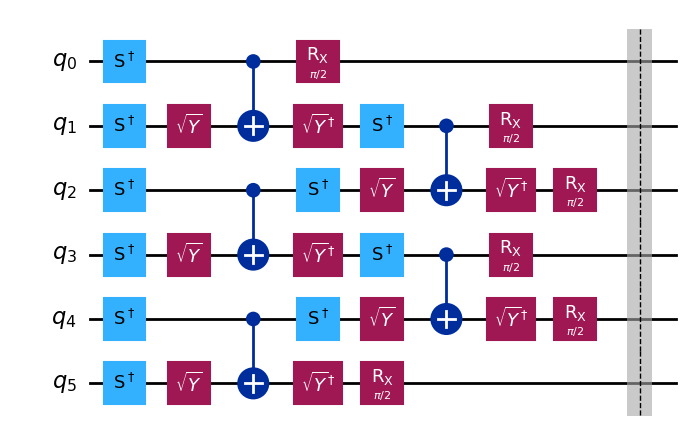

In [2]:
num_qubits = 6 
num_trotter_steps = 1
rx_angle =  0.5*np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output = 'mpl')

## Demo: Sampler

In [4]:
def append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle)

        if trotter_barriers: 
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):

    qc.rx(-rx_angle, list(range(qc.num_qubits)))    
    if layer_barriers:
        qc.barrier() 

    # for adding RZZ layes in the odd layers
    for i in range(1, qc.num_qubits-1,2):
        qc.append(SYGate, [i+1])       
        qc.cx(i, i+1)
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier() 
       
    # for adding RZZ layes in the even layers
    for i in range(0, qc.num_qubits-1,2):
       qc.append(SYGate, [i+1])
       qc.cx(i, i+1)
       qc.s([i, i+1])
    if layer_barriers:
        qc.barrier() 

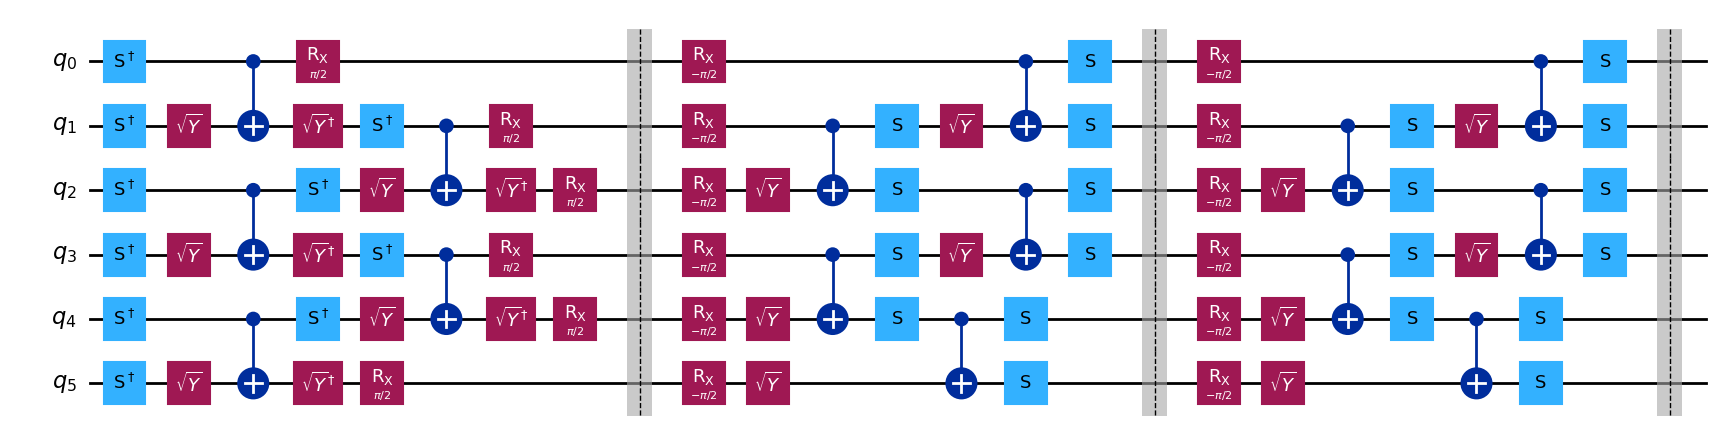

In [6]:
append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output='mlp', fold = -1)

## Step 1: Map the problem to circuits and observables

In [ ]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49,50]

qc_list = []

for trotter_step in range(max_trotter_steps):
    generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_qubits, [0,1])
    qc_list.append